# Grover's Algorithm
<hr></hr>

[Grover's algorithm](https://en.wikipedia.org/wiki/Grover%27s_algorithm), introduced by [Lov Grover](https://en.wikipedia.org/wiki/Lov_Grover) in 1996, marked the second major discovery of a quantum algorithm with potential practical applications, appearing only a few years after Shor’s factoring algorithm. However, unlike Shor’s exponential speedup, Grover’s algorithm provides only a polynomial advantage (specifically, **quadratic**) over the best known classical approaches [[Grover96](https://dl.acm.org/doi/pdf/10.1145/237814.237866)]. In other words, for certain problems that require $N$ steps classically, Grover’s algorithm can find a solution with high probability in roughly $\sqrt{N}$ steps.

Grover's algorithm is also known as the quantum search algorithm, as it addresses the problem of finding the inputs to an arbitrary function that evaluate to some specified output value. More precisely, the class of problems it solves can be formulated as instances of an unstructured search, where given a Boolean function $f: \{0, 1\}^n \longmapsto \{0, 1\}$, the goal is to find all inputs $x \in  \{0, 1\}^n$ that evaluate to $f(x) = 1.$

A popular example used to describe Grover's algorithm is the task of searching through a phone book to find the person associated with a specific phone number. This is a challenging task because, even though names are listed alphabetically, phone numbers themselves are unordered. So, if there are a total of $N$ entries, a classical search may require checking each entry one by one until the number we're looking for is found. In the worst case, this requires going over each of the $N$ values. And for multiple of these searches, it takes on average $N/2$ tries. In contrast, Grover's algorithm can solve this problem by querying the list only $\sqrt{N}$ times. However, as with the other quantum algorithms we've discussed so far, Grover’s algorithm requires encoding the problem of interest into a unitary oracle $U_f.$ For a purely classical search task (such as scanning a phone book), constructing the function $f(x)$ needed to build $U_f$ would itself require examining the entire list of numbers ahead of time. Therefore, Grover's algorithm offers no practical advantage in this particular example. It is then crucial to recognize that, even though this example is helpful from a pedagogical standpoint, Grover’s algorithm is of practical use **only** when the function $f(x)$ can be implemented and encoded into $U_f$ in an efficient manner. An important task where this condition holds is in the [circuit satisfiability problem](https://en.wikipedia.org/wiki/Circuit_satisfiability_problem), which we will discuss later.

For convenience, we begin by formulating the unstructured search problem under the assumption that the unitary $U_f$ is simply given to us. This mirrors our treatment of the Deutsch–Jozsa, Bernstein–Vazirani, and Simon algorithms, where, given access to $U_f,$ we compare the number of queries required when it is evaluated using only classical inputs with the number required when quantum operations are allowed.

## 1. Classical Approach

A good starting point is to consider a function $f(x)$ for which only **one** unknown value of $x$ evaluates to $1$ (we will generalize the problem for $M$ unknown values in section 3). It is common to refer to this value as a **marked element**. Below is an example of a function for which the marked element is $m = 101:$

$$
\begin{split}
\begin{aligned}
f(000) &= 0
\\
f(001) &= 0
\\
f(010) &= 0
\\
f(011) &= 0
\\
f(100) &= 0
\\
f(101) &= 1
\\
f(110) &= 0
\\
f(111) &= 0
\end{aligned}
\end{split}
$$

Let's use python to create a function $f(x),$ which evaluates to $1$ for a random marked element $m.$

In [1]:
import numpy as np

In [2]:
def fx_single_m(n):
    N = 2**n
    fx_lst = [0]*N
    
    m_int = np.random.randint(N)
    fx_lst[m_int] = 1
    
    return fx_lst, m_int

In [3]:
n = 3 # number of bits

fx_lst, m_int = fx_single_m(n)
m = np.binary_repr(m_int,n)

print(f'Outcomes for m = {m}\n')
print('x',' '*(n), 'f(x)')

for x_int, fx_int in enumerate(fx_lst):
    x = np.binary_repr(x_int,n)
    fx = np.binary_repr(fx_int,1)
    
    print(x, ' ', fx)

Outcomes for m = 011

x     f(x)
000   0
001   0
010   0
011   1
100   0
101   0
110   0
111   0


As mentioned above, the only way of finding a marked element classically is by evaluating $f(x)$ for each input $x$ until we get an output equal $1$. The probability of succeeded after trying $r$ different inputs is simply given by the ratio between the number of tries and the total number of possible inputs:

$$\mathbb{P}_{\text{success}} = \frac{r}{2^n} .$$

Let us now encode $f(x)$ into a unitary $U_f$ using qiskit:

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import AerSimulator

In [5]:
def black_box_single_m(n):
    N = 2**n
    m_int = np.random.randint(N)
    m = np.binary_repr(m_int,n)
    
    qc_bb = QuantumCircuit(n+1)
    qc_bb.mcx(list(range(1,n+1)),0, ctrl_state=m)
    
    return qc_bb, m

circuit that encodes f(x)=1 for x = 0111


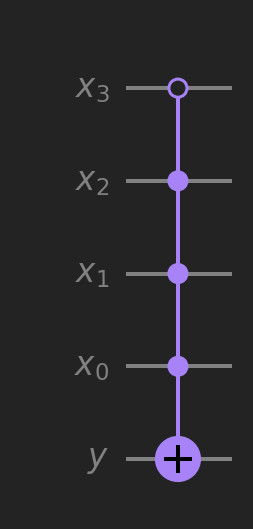

In [6]:
# Draw example circuit for f(x) = 1 when x is the marked element m.
n = 4
bb, m = black_box_single_m(n)

xr = QuantumRegister(n, name='x')
yr = QuantumRegister(1, name='y')

qc = QuantumCircuit(yr,xr)
qc.append(bb,range(n+1))

print(f'circuit that encodes f(x)=1 for x = {m}')
qc.decompose().draw()

As can be seen, the black box circuit is very simple. It consists of an $MCX$ gate for which the controls activate the $X$ gate only when the input $x = m.$ We can then run a simulation for one unknown marked element and see how many accesses to $U_f$ it takes to find it:

In [8]:
n = 5                          # Length (in bits) of marked element
N = 2**n                       # Number of possible values x can take
simulator = AerSimulator()

bb, m = black_box_single_m(n)  # Generate black box and secret string

for x_in in range(N):
    
    qc = QuantumCircuit(n+1,1)
    qc.prepare_state(x_in,range(1,n+1))
    qc.append(bb,range(n+1))
    qc.measure(0,0)

    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation per black box 

    fx = job.result().get_memory()[0]

    if fx == '1':
        break
        
print(f'marked element: {m}')
print(f'found after: {x_in} tries out of {N}')

marked element: 10111
found after: 23 tries out of 32


The plot below shows the results of running the simulation above a large number of times for random marked elements of length $n = 5$. As can be seen, it requires going over all $N$ elements to guarantee finding the marked element with $100 \%$ probability. Furthermore, the expected probability of success increases as $r/2^n.$ This implies that, it takes $r = 2^n/2 = 2^{n-1}$ tries to find the marked element $m$ with more than $50 \%$ probability, which for $n = 5,$ is $r = 16:$

<img src="images/04_04_01_classical_probs.png" align = "center" width="600"/>

The main takeaway here is that, as the number of possible inputs $N = 2^n$ increases, the number of times we need to access the oracle $U_f$ to find $m$ with high probability also increases linearly with $N.$

## 2. Quantum Approach

Grover's algorithm follows a similar set of steps to those we've used in previous algorithms, where we:

1. Place all inputs in an equal superposition using the Quantum Hadamard Transform $(\text{QHT}).$
2. Evaluate a function of interest $U_{f(x)}$ (which encodes our problem) over the equal superposition state.
3. Perform constructive/destructive interference using the $\text{QHT}$.
4. Measure the top register to extract relevant information about our solution.

<img src="images/04_04_02_algo_compare.png" align = "center" width="1100"/>

However, as we will see next, in Grover's algorithm the interference step is performed by a unitary different from the $\text{QHT}.$ The role of this operation is to amplify the probability of measuring the marked element $m.$ Moreover, the amount of amplification achieved in each iteration depends on the total number of elements $N$, meaning that the circuit must be applied repeatedly to maximize the probability of measuring $m$ in the top register. What's critical though, is that the number of repetitions (and therefore the number of calls to $U_f$) scales proportional to $\sqrt{N},$ representing a quadratic improvement over the classical approach described in [section 1](#1.-Classical-Approach), which required a number of calls to $U_f$ on the order of $N.$

### 2.1 Quantum Circuit

The image below shows a general sketch of the quantum circuit used in Grover's algorithm. 

<img src="images/04_04_03_grover.png" align = "center" width="450"/>

Like with other algorithms, we start by placing the input in an equal superposition over all $N = 2^n$ possible values of $x \in \{0, 1\}^n.$ 

Next, we perform quantum function evaluation, where $U_f$ encodes the function $f(x)$, which equals $1$ only for the input $x = m.$ As mentioned above, the function evaluation step is now followed by a unitary $V,$ commonly known as Grover's **Amplification** or **Diffusion** operator. $V$ still performs constructive/destructive interference just like the $\text{QHT}$ does in other algorithms, but in a more subtle way. $V$ is responsible of **amplifying** the probability amplitude associated with the marked element $m$, and **diffusing** the amplitudes of all other elements.

An important aspect of this amplification step is that, since the amount by which the probability of interest increases depends on the total number of elements in the search space, we must repeat the application of $U_f$ and $V$ a certain number of times $\kappa$ to guarantee that the measured output is the marked element $m$ with high probability.

Let's go over each circuit step to understand the role of the diffuser $V,$ and why $U_f$ and $V$ might need to be repeated more than once before measurement. We will accompany the procedure with an example for 3 qubits, where the marked element is $m = 101.$ 

<img src="images/04_04_04_grover_steps.png" align = "center" width="700"/>

<span style="font-size: 14px;">**NOTE:** In the diagram above, we show $U_f$ and $V$ applied twice ($\kappa = 2$) to match our example, but as we will see in the next few sections, the number of repetitions $\kappa$ depends on the ratio between the number of marked elements $M$ and the total number of elements $N.$</span>

As a matter of convenience, we are going to rely on the fact that any quantum state can be written as a superposition of computational basis states $\{|0\rangle, |1\rangle\}^{\otimes n}.$ Given that the bottom qubit always remains in the $|-\rangle$ state (for phase kickback) we can express the overall state at any point in the circuit as:

$$ |\psi\rangle_t = \left(\sum_{x=0}^{N-1} \alpha_x^{(t)} |x\rangle \right) \otimes |-\rangle, $$

where $t$ is an arbitrary step in the circuit, and $\alpha_x^{(t)}$ are the probability amplitudes associated with each basis state $|x\rangle$ at that particular step. We will then track the changes to the probability amplitudes $\alpha_x^{(t)}$ after each circuit step,  replaced in the expression above to get the total state if needed.

0. We start by initializing the top register in the all-zeros state and the bottom qubit in the minus state $|\psi\rangle_0 = |0\rangle^{\otimes n} \otimes |-\rangle .$ This gives probability amplitudes for register $x$ of:

$$ \alpha_x^{(0)} = \begin{cases} 
1,  & \text{if } x = 0
\\
\\
0, & \text{otherwise }.
\end{cases} $$

In the case of our 3-qubit example, at initialization we have state $|000\rangle$ with amplitude of $1$, and all other states with amplitudes of $0,$ which we will display graphically for clarity:

<img src="images/04_04_05_grover_step01.png" align = "center" width="600"/>

1. Next, we apply the $\text{QHT}$ to register $x$: $|\psi\rangle_1 = \text{QHT}_n |0\rangle^{\otimes n} \otimes |-\rangle .$

This places the top register in an equal superposition over all possible values of $x,$ so all amplitudes take the same value:

$$\alpha_x^{(1)} = \frac{1}{\sqrt{N}}, \; \forall \; x.$$

For the 3-qubit example, this sets the probability amplitudes of all basis state to the same value of  $\alpha_x^{(1)} = 1 \big/\sqrt{8} \approx 0.3535:$

<img src="images/04_04_06_grover_step02.png" align = "center" width="600"/>

2. This is followed by evolving the state through the black box: $|\psi\rangle_2 = U_f |\psi\rangle_1,$ which consists of performing quantum function evaluation over the superposition state. As we've seen before, for an arbitrary state $|x\rangle,$ applying $U_f$ (with the bottom qubit in state $|-\rangle$) results a state of the form $(-1)^{f(x)} |x\rangle.$ Here we can note that, only for the marked element $m$ (for which $f(x) = 1$) its amplitude sees a sign inversion: $(-1)^{1} = -1.$ For all other states, we have $f(x) = 0,$ so their amplitudes remain unchanged: $(-1)^{0} = 1.$

$$ \alpha_x^{(2)} = \begin{cases} 
\phantom{-} \frac{1}{\sqrt{N}},  & \text{if } x \neq m
\\
\\
-\frac{1}{\sqrt{N}}, & \text{if } x = m .
\end{cases} $$

For our example, we have $|101\rangle$ as our marked element, so this basis state will experience a change in sign:

<img src="images/04_04_07_grover_step03.png" align = "center" width="600"/>

3. We then perform amplitude amplification by evolving the state through the diffuser: $|\psi\rangle_3 = (V \otimes I) |\psi\rangle_2.$ The way the diffuser accomplishes this is by flipping all amplitudes about the **mean** value $\mu$, which is given by the sum of all amplitudes divided by the number of elements:

$$ \mu^{(2)} = \frac{1}{N} \sum_{x = 0}^{N-1} \alpha_x^{(2)}. $$

Since at this point we have $(N - 1)$ elements with amplitude of $\alpha_{x \neq m}^{(2)} = 1 \big / \sqrt{N}$ and $1$ element with probability of $\alpha_{x = m} = -1 \big / \sqrt{N},$ we can simplify the expression above as:

$$ 
\begin{aligned}
\mu^{(2)} &= \frac{1}{N} \left((N - 1)\frac{1}{\sqrt{N}} - \frac{1}{\sqrt{N}} \right) 
\\
\\
\mu^{(2)} &= \frac{1}{\sqrt{N}}\frac{N-2}{N},
\end{aligned}
$$


which for our example results in a mean value of:

$$ \mu^{(2)} = \frac{1}{\sqrt{8}}\frac{8-2}{8} \approx 0.265 .$$

To understand how the inversion about the mean works, it is helpful to show the relative distances between each probability amplitude to the mean (dotted line) given by $\alpha_x^{(2)} - \mu^{(2)}:$

<img src="images/04_04_08_grover_step03b.png" align = "center" width="600"/>

So after applying the diffuser there is a "reflection", which flips the probability amplitudes with respect to the dotted line. The distance with respect to the mean is still the same, just in the opposite direction:

<img src="images/04_04_09_grover_step04.png" align = "center" width="600"/>

We can then calculate the new probability amplitudes $\alpha_x^{(3)}$ after the diffuser, by subtracting this distance ($\alpha_x^{(2)} - \mu^{(2)}$) from the mean:

$$ 
\begin{aligned}
\alpha_x^{(3)} &= \mu^{(2)} - \left(\alpha_x^{(2)} - \mu^{(2)} \right)
\\
\\
\alpha_x^{(3)} &= 2\mu^{(2)} - \alpha_x^{(2)} .
\end{aligned}
$$

Replacing $\mu^{(2)}$ and $\alpha_x^{(2)}$ in the expression above, we can calculate the new probability amplitudes as:

$$ \alpha_x^{(3)} = \begin{cases} 
\frac{1}{\sqrt{N}}\frac{N-4}{N},  & \text{if } x \neq m
\\
\\
\frac{1}{\sqrt{N}}\frac{3N-4}{N}, & \text{if } x = m .
\end{cases} $$

Since for 2 or more qubits we have: $N \geq 4,$ the result above shows that applying $V$ causes the probability amplitude of the marked element to increase in magnitude. This is evident in our example, where the new amplitude of the marked element is now clearly larger than that of the rest of the elements:

<img src="images/04_04_10_grover_step04b.png" align = "center" width="600"/>

Specifically, we get:

$$ \alpha_x^{(3)} = \begin{cases} 
\frac{1}{\sqrt{8}}\frac{8-4}{8} \approx 0.177,  & \text{if } x \neq 101
\\
\\
\frac{1}{\sqrt{8}}\frac{3 \cdot 8 - 4}{8} \approx 0.884, & \text{if } x = 101 .
\end{cases} $$

This means that, if we were to perform a measurement after applying $V,$ we will find out marked element $m = 101$ with probability:

$$ \mathbb{P}_{x = 101} \approx \left | 0.884 \right |^2 \approx 0.78 .$$

4. Surprisingly, we can do even better. If instead of measuring right away, we instead apply $U_f$ again, this invert the sign of the marked element once more:

$$ \alpha_x^{(4)} = \begin{cases} 
\phantom{-}\frac{1}{\sqrt{N}}\frac{N-4}{N},  & \text{if } x \neq m
\\
\\
-\frac{1}{\sqrt{N}}\frac{3N-4}{N}, & \text{if } x = m .
\end{cases} $$

<img src="images/04_04_11_grover_step05.png" align = "center" width="600"/>

5. We can also recompute the mean:

$$ \mu^{(4)} = \frac{1}{N} \sum_{x = 0}^{N-1} \alpha_x^{(4)}, $$

and find the new probability amplitudes that result from reflecting about the mean after applying $V$ again:

$$ \alpha_x^{(5)} = 2\mu^{(4)} - \alpha_x^{(4)} .$$

Replacing the new average value $\mu^{(4)}$ and the probability amplitudes $\alpha_x^{(4)}$ for marked and unmarked elements give us:

$$ \alpha_x^{(5)} = \begin{cases} 
\frac{1}{\sqrt{N}}\frac{N^2-12N+16}{N},  & \text{if } x \neq m
\\
\\
\frac{1}{\sqrt{N}}\frac{5N^2-20N+16}{N}, & \text{if } x = m .
\end{cases} $$

For the case of $N \geq 8$ (like in our example), the magnitude of the probability amplitude of the marked element increases even further:

<img src="images/04_04_12_grover_step06.png" align = "center" width="600"/>

Specifically, we get:

$$ \alpha_x^{(5)} = \begin{cases} 
\frac{1}{\sqrt{8}}\frac{8^2-12 \cdot 8 +16}{8} \approx -0.088,  & \text{if } x \neq m
\\
\\
\frac{1}{\sqrt{8}}\frac{5 \cdot 8^2-20 \cdot 8 + 16}{8} \approx 0.972, & \text{if } x = m ,
\end{cases} $$

which results in a probability of measuring the marked element of:

$$ \mathbb{P}_{x = 101} \approx \left | 0.972 \right |^2 \approx 0.945 .$$

So after two applications of the oracle $U_f$ and the diffuser $V,$ we have managed to increase the probability of measuring the marked element from $12.5 \%$ all the way up to $94.5 \%.$

Unfortunately, adding one more application of $U_f$ and $V$ decreases our chances of measuring the marked element. This occurs because the success probability follows a cyclical behavior rather than increasing monotonically. To understand why this is the case, and to determine the optimal number of iterations for a given number of elements, we must analyze Grover’s algorithm from a geometric perspective. Before doing so, however, let's first examine how to construct the circuit that implements Grover’s diffuser $V.$

#### 2.1.1 Grover's Amplification/Diffusion Operator

As mentioned in the previous section, the role of Grover's amplification operator $V$ is to reflect all probability amplitudes about their mean value. So, given an arbitrary state at some point $t$:

$$ |\psi\rangle_t = \sum \alpha_x^{(t)} |x\rangle, $$

applying $V$ evolves the state to the next step $t+1$ as:

$$ 
\begin{aligned}
|\psi\rangle_{t+1} &= V|\psi\rangle_{t}
\\
\\
|\psi\rangle_{t+1} &= \sum \alpha_x^{(t+1)} |x\rangle
\end{aligned}
$$

where the new probability amplitudes are calculated as:

$$ \alpha_x^{(t+1)} = 2 \mu^{(t)} - \alpha_x^{(t)} .$$

Here, $\mu^{(t)}$ is the mean amplitude in step $t$:

$$ \mu^{(t)} = \frac{1}{N} \sum_{x=0}^{N -1} \alpha_x^{(t)} .$$


In [15]:
N = 2**3

(1/np.sqrt(N)*(3*N-4)/N)

0.7812499999999999

0.944784

In [18]:
(1/np.sqrt(N)*(5*N**2-20*N+16)/N**2)**2

0.9453124999999998

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator

qc = QuantumCircuit(3)